<a href="https://colab.research.google.com/github/saptarshidatta96/DigitRecognizerCNN/blob/master/VGG16_based_SVC_One_vs_Rest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import itertools
import os
import os.path
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import os 
import xml.etree.ElementTree as ET
from collections import OrderedDict
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Mounting Google Drive to access the dataset previously uploaded to gdrive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Un-tar out dataset

In [3]:
!tar -xvf "/content/gdrive/MyDrive/VOCtrainval_11-May-2012.tar" -C "/content/"  

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

Parse the XML files under Annotations folder to assign a class to each image.

In [5]:
def parseXML(tree):
  roww = OrderedDict()
  for elements in tree.iter():
    if elements.tag == 'filename':
      roww['{}'.format(elements.tag)] = str(elements.text)
    if elements.tag =='object':
      for element in elements:
        if element.tag == 'name':
          roww['{}'.format(element.tag)] = str(element.text)
  return roww



In [6]:
df_annot = []
for file in os.listdir('/content/VOCdevkit/VOC2012/Annotations'):
  if file.startswith('.') == 0:
    tree = ET.parse(os.path.join('/content/VOCdevkit/VOC2012/Annotations', file))
    roww = parseXML(tree)
    df_annot.append(roww)

df_annotation = pd.DataFrame(df_annot)

Display any random 5 images present in the Dataset. Notice that the size of the images vary.

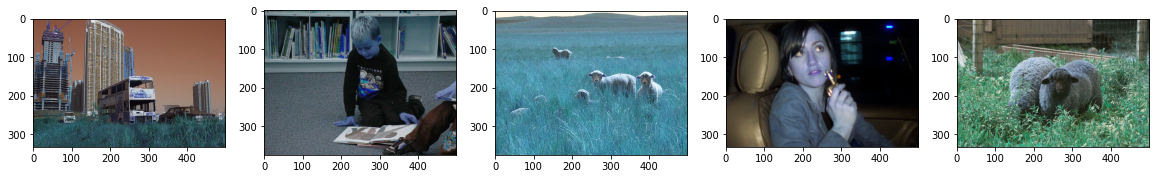

In [37]:
random.seed(42)
img_list = []
img_dir = '/content/VOCdevkit/VOC2012/JPEGImages'
img_files = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
random_images = [cv2.imread(x)for x in random.sample(img_files, 5)]
plt.figure(figsize = (20,10))
columns = 5
for index, image in enumerate(random_images):
  plt.subplot(len(random_images)/columns +1, columns, index+1)
  plt.imshow(image)

In [7]:
list_of_unique_class =df_annotation['name'].unique()
list_of_files = df_annotation['filename'].unique()
annotations_list = df_annotation.values.tolist()

Length of the dataset

In [8]:
len(annotations_list)

17125

Using only 10% of the images for training and 2% of the images for testing.

In [9]:
df_train_sample = df_annotation.sample(frac = 0.10)
train_sample = df_train_sample.values.tolist()
validation_sample = df_annotation.drop(df_train_sample.index).sample(frac = 0.02).values.tolist()

In [10]:
list_of_unique_class

array(['cat', 'person', 'sheep', 'bird', 'pottedplant', 'chair', 'bus',
       'sofa', 'bottle', 'car', 'tvmonitor', 'cow', 'diningtable',
       'aeroplane', 'dog', 'motorbike', 'train', 'horse', 'boat',
       'bicycle'], dtype=object)

Downloading pre-trained VGG 16 model from Tensorflow.

In [11]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553476096/553467096 [==============================] - 4s 0us/step


Removing the last prediction layer from our VGG 16 pre-tarined model and taking outputs from the next to last layer. The length of tensors generated will be `(1, 4096)`

In [12]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

for layer in model.layers:
  layer.trainable = False

extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers][20])

pass the images to our VGG 16 NN. Before passing, we resize the images to `(224, 224)` as expected by the VGG-16 architecture. As tensors with length `(1,4096)` are generated by the NN, we convert those tensors to numpy arrays which will be further used as inputs to the SVC One vs Rest Classifier.

In [13]:
def output_nn(sample):
  output = []
  class_name = []
  for entry in train_sample:
    image = Image.open('/content/VOCdevkit/VOC2012/JPEGImages/{}'.format(entry[0]))
    image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    features = extractor(tf.expand_dims(image_tensor, axis=0)).numpy()
    features = np.squeeze(features, axis=0)
    output.append(features)
    class_name.append(entry[1])

  return output, class_name

In [14]:
svc_model = OneVsRestClassifier(SVC())

In [15]:
def train_svc(sample):
  train_output, train_class_name = output_nn(sample)
  svc_model.fit(train_output, train_class_name)

Training our model...

In [16]:
train_svc(train_sample)

In [17]:
def test_svc(sample):
  test_output, test_class_name = output_nn(sample)
  prediction = svc_model.predict(test_output)

  return test_class_name, prediction

Testing our model...

In [18]:
test_class_name, prediction = test_svc(validation_sample)

Overall Accuracy

In [19]:
accuracy_score(test_class_name, prediction)

0.9462616822429907

In [24]:
output = pd.DataFrame({'Actual': test_class_name,
                       'Predicted': prediction})
output.sort_values('Actual', inplace = True)

Class wise Accuracy, Confusion Matrix and Classification Metrics

In [21]:
for class_name in list_of_unique_class:
  print('|--------------------------------------------------------------|')
  output_class_specific = output.loc[output['Actual'] == class_name]
  print('Class:', class_name)
  print('Accuracy:{:.2f}%'.format(accuracy_score(output_class_specific['Actual'], output_class_specific['Predicted'])*100))
  print('Confusion Matrix:\n', confusion_matrix(output_class_specific['Actual'], output_class_specific['Predicted']))
  print('Classification Report:\n', classification_report(output_class_specific['Actual'], output_class_specific['Predicted']))
  print('\n')



|--------------------------------------------------------------|
Class: cat
Accuracy:98.88%
Confusion Matrix:
 [[88  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         cat       1.00      0.99      0.99        89
      person       0.00      0.00      0.00         0

    accuracy                           0.99        89
   macro avg       0.50      0.49      0.50        89
weighted avg       1.00      0.99      0.99        89



|--------------------------------------------------------------|
Class: person
Accuracy:98.85%
Confusion Matrix:
 [[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  2   2   2   1 773   2]
 [  0   0   0   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

   aeroplane       0.00      0.00      0.00         0
        boat       0.00      0.00      0.00         0
         car       0.00      0.00      0.00         0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
 [[74  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

   aeroplane       1.00      0.99      0.99        75
      person       0.00      0.00      0.00         0

    accuracy                           0.99        75
   macro avg       0.50      0.49      0.50        75
weighted avg       1.00      0.99      0.99        75



|--------------------------------------------------------------|
Class: dog
Accuracy:98.80%
Confusion Matrix:
 [[82  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         dog       1.00      0.99      0.99        83
      person       0.00      0.00      0.00         0

    accuracy                           0.99        83
   macro avg       0.50      0.49      0.50        83
weighted avg       1.00      0.99      0.99        83



|--------------------------------------------------------------|
Class: motorbike
Accuracy:87.88%
Confusion Matrix:
 [[29  4]


In [22]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix for the 20 classes at one go.

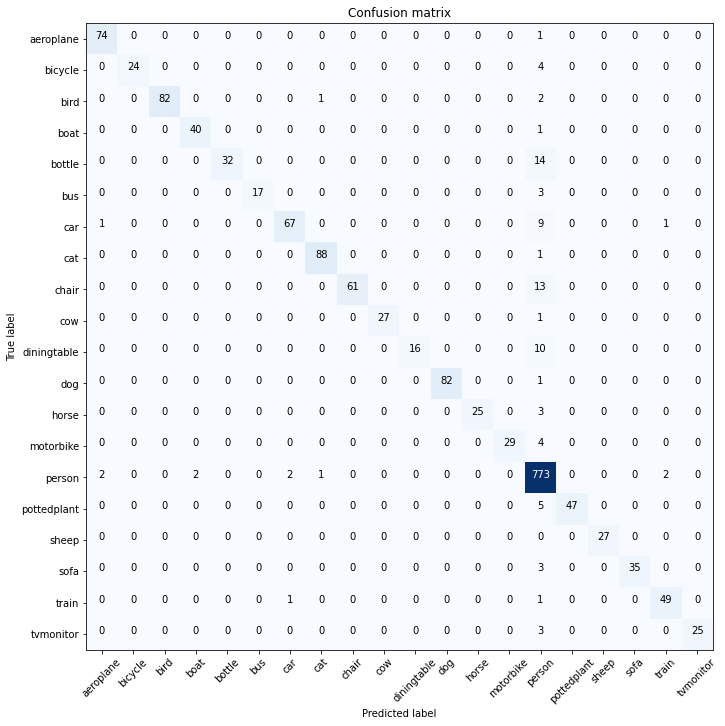

In [28]:
cm = confusion_matrix(output['Actual'], output['Predicted'])
classes = output['Actual'].unique()
plt.figure(figsize=(10, 13))
plot_confusion_matrix(cm, classes)